In [50]:
# %% Import Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import joblib
import random
from tensorflow.keras import layers, models


In [51]:
# %% Load and Preprocess Annotations
DIR = 'Fish_Dataset1'
annotations = []

for category in os.listdir(DIR):
    category_path = os.path.join(DIR, category)
    if not os.path.isdir(category_path):
        continue
    for subcategory in os.listdir(category_path):
        subcategory_path = os.path.join(category_path, subcategory)
        if not os.path.isdir(subcategory_path) or "GT" in subcategory:
            continue
        for filename in os.listdir(subcategory_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(subcategory_path, filename)
                annotations.append({'filename': file_path, 'class_label': category})

annotations_df = pd.DataFrame(annotations)
annotations_df.to_csv("annotations.csv", index=False)
print(f"Total images found: {len(annotations)}")


Total images found: 2200


In [52]:
# %% Extract Bounding Boxes
annotations = []
root_dir = "Fish_Dataset1"

for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if not os.path.isdir(category_path):
        continue
    image_dir = os.path.join(category_path, category)
    mask_dir = os.path.join(category_path, f"{category} GT")
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        continue
    for image_file in os.listdir(image_dir):
        if image_file.endswith('.png'):
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, image_file)
            if os.path.exists(mask_path):
                annotations.append({
                    "category": category,
                    "image_path": image_path,
                    "mask_path": mask_path
                })

annotations_df = pd.DataFrame(annotations)
annotations_df.to_csv("annotations.csv", index=False)
print(f"Annotations saved. Total: {len(annotations)}")


Annotations saved. Total: 2200


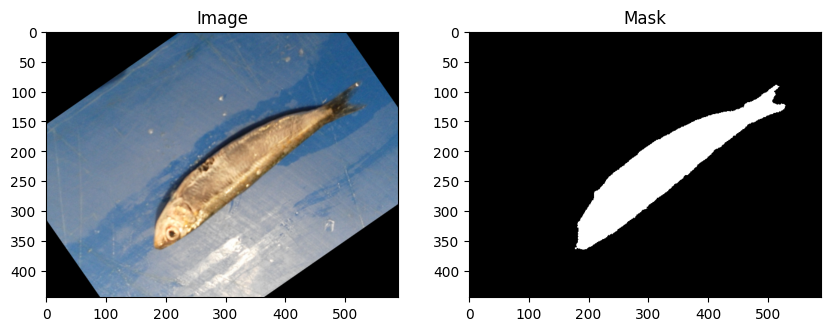

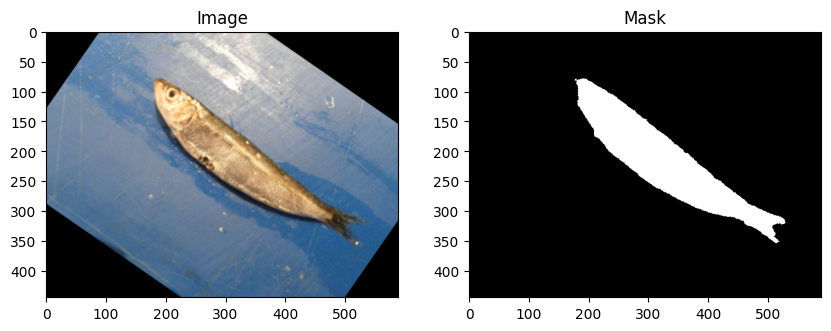

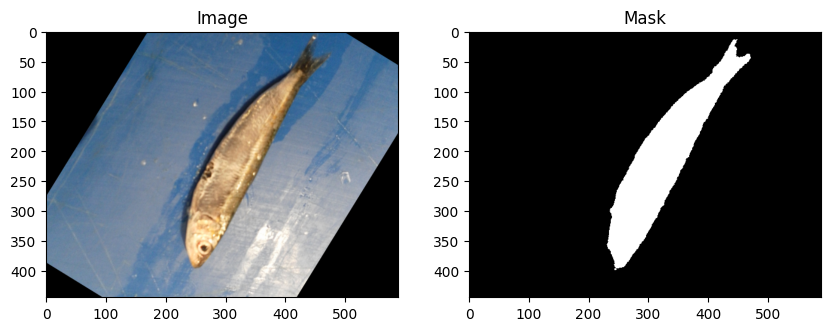

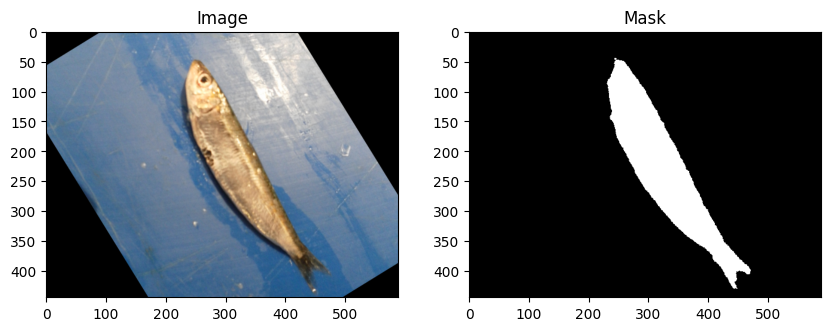

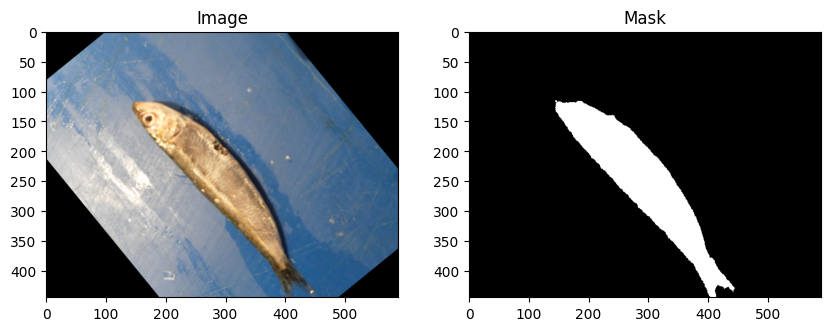

In [53]:
# %% Visualize Images and Masks
annotations = pd.read_csv("annotations.csv")

for i in range(5):  # Display 5 examples
    row = annotations.iloc[i]
    image = cv2.imread(row['image_path'])
    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)

    if image is not None and mask is not None:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.show()


In [54]:
# %% Encode Labels
label_encoder = LabelEncoder()
annotations['category'] = label_encoder.fit_transform(annotations['category'])
joblib.dump(label_encoder, "label_encoder.pkl")

print("After Encoding:")
print(annotations.head())
print(annotations['category'].unique())


After Encoding:
   category                                         image_path  \
0         0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat\...   
1         0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat\...   
2         0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat\...   
3         0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat\...   
4         0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat\...   

                                           mask_path  
0  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat ...  
1  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat ...  
2  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat ...  
3  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat ...  
4  Fish_Dataset1\Black Sea Sprat\Black Sea Sprat ...  
[0 1 2 3 4 5 6 7 8]


In [55]:
# %% Add Bounding Box Information
def mask_to_bbox(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    coords = np.column_stack(np.where(mask > 0))
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    return x_min, y_min, x_max, y_max

annotations['bbox'] = annotations['mask_path'].apply(mask_to_bbox)
annotations.dropna(inplace=True)

annotations[['x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(
    annotations['bbox'].tolist(), index=annotations.index
)
annotations.to_csv("annotations_with_bbox.csv", index=False)


In [56]:
# %% Preprocess Data with Bounding Box
def preprocess_data(data_row, augment=False):
    image = cv2.imread(data_row['image_path'])
    if image is None:
        return None, None, None
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize image
    bbox = data_row[['x_min', 'y_min', 'x_max', 'y_max']].astype(float).values / [224, 224, 224, 224]  # Normalize bbox
    label = int(data_row['category'])  # Integer label
    return image, bbox, label

def create_tf_dataset(data, augment=False):
    images, bboxes, labels = [], [], []
    for _, row in data.iterrows():
        image, bbox, label = preprocess_data(row, augment=augment)
        if image is not None:
            images.append(image)
            bboxes.append(bbox)
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, {'bbox': bboxes, 'category': labels}))


train_data, val_data = train_test_split(annotations, test_size=0.2, random_state=42)
train_dataset = create_tf_dataset(train_data).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = create_tf_dataset(val_data).batch(8).prefetch(tf.data.AUTOTUNE)


In [57]:
def iou_metric(y_true, y_pred):
    """
    Beregner Intersection over Union (IoU) mellom to bounding boxes.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

    union = area_true + area_pred - intersection
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    return tf.reduce_mean(iou)


In [58]:


def build_model():
    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox')(x)  # Output for bounding box
    category_output = layers.Dense(len(annotations['category'].unique()), activation='softmax', name='category')(x)  # Output for category
    return models.Model(inputs=inputs, outputs={'bbox': bbox_output, 'category': category_output})

model = build_model()
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_11[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category (Dense)    │ (None, 9)         │      1,161 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,925 (370.80 KB)

 Trainable params: 94,925 (370.80 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# %% Compile and Train Model
# %% Compile Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'bbox': iou_loss,  # Bruk IoU-loss for bounding boxes
        'category': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'bbox': 1.0,
        'category': 1.0
    },
    metrics={
        'bbox': [iou_metric],  # Behold IoU som metrikk
        'category': 'accuracy'
    }
)


history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - bbox_iou_metric: 2.5496e-09 - bbox_loss: 1.0000 - category_accuracy: 0.1268 - category_loss: 2.1917 - loss: 3.1917 - val_bbox_iou_metric: 4.9214e-07 - val_bbox_loss: 1.0000 - val_category_accuracy: 0.1750 - val_category_loss: 2.1679 - val_loss: 3.1679
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - bbox_iou_metric: 0.0015 - bbox_loss: 0.9985 - category_accuracy: 0.1951 - category_loss: 2.1399 - loss: 3.1384 - val_bbox_iou_metric: 0.0405 - val_bbox_loss: 0.9595 - val_category_accuracy: 0.2318 - val_category_loss: 1.9923 - val_loss: 2.9518
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - bbox_iou_metric: 0.0712 - bbox_loss: 0.9288 - category_accuracy: 0.2754 - category_loss: 1.9171 - loss: 2.8460 - val_bbox_iou_metric: 0.0969 - val_bbox_loss: 0.9031 - val_category_accuracy: 0.3136 - val_category_loss: 1.7104 - val_loss: 2.6136
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - bbox_iou_metric: 0.0995 - bbox_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


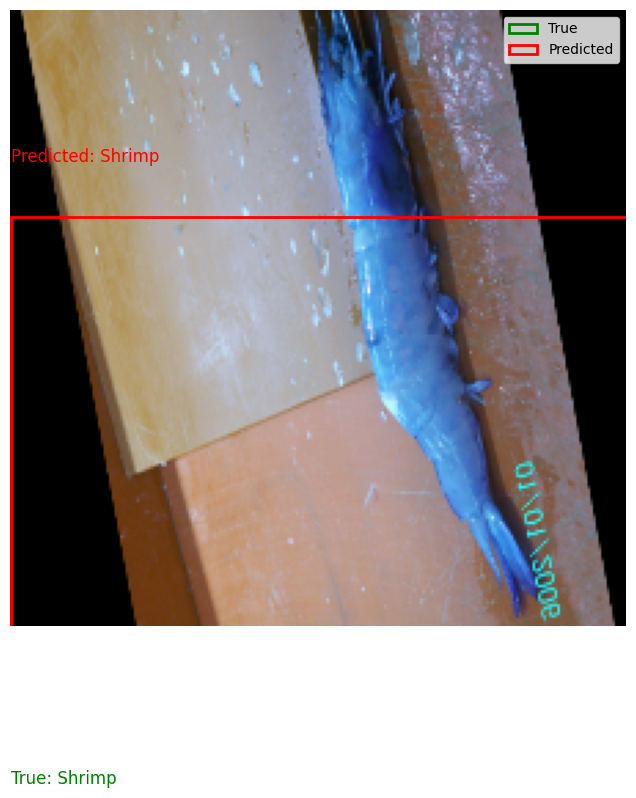

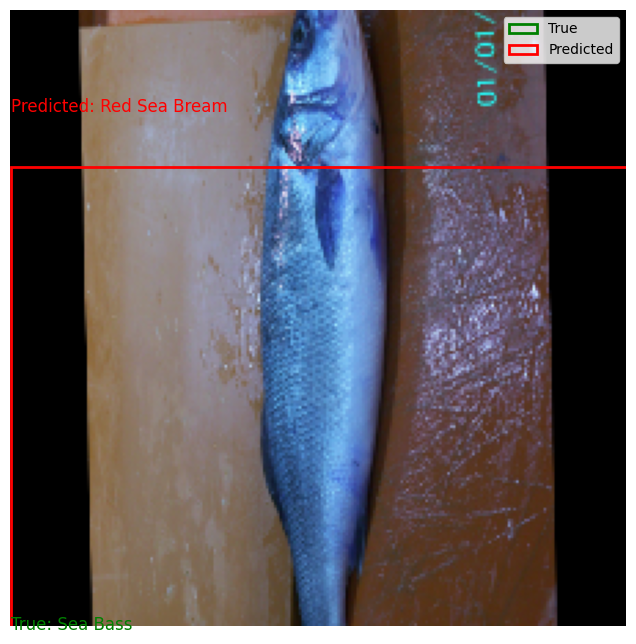

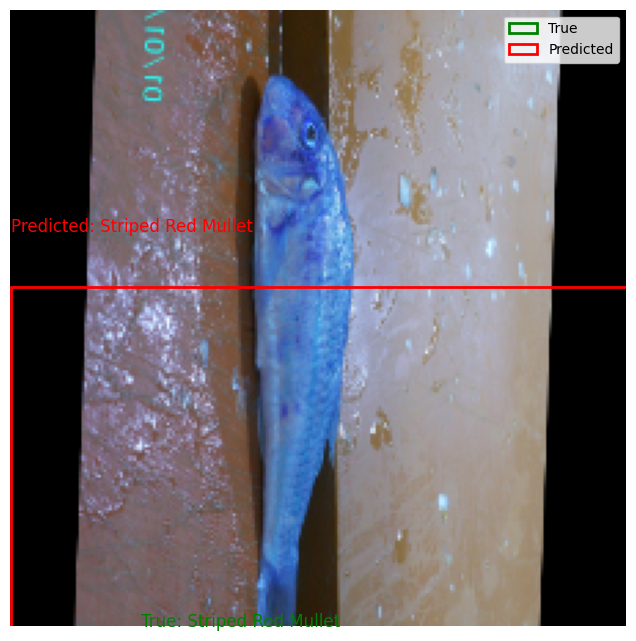

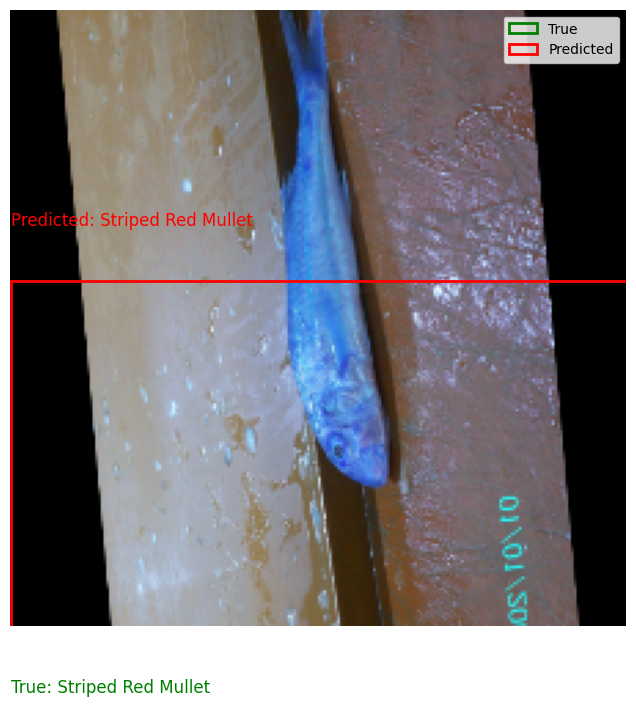

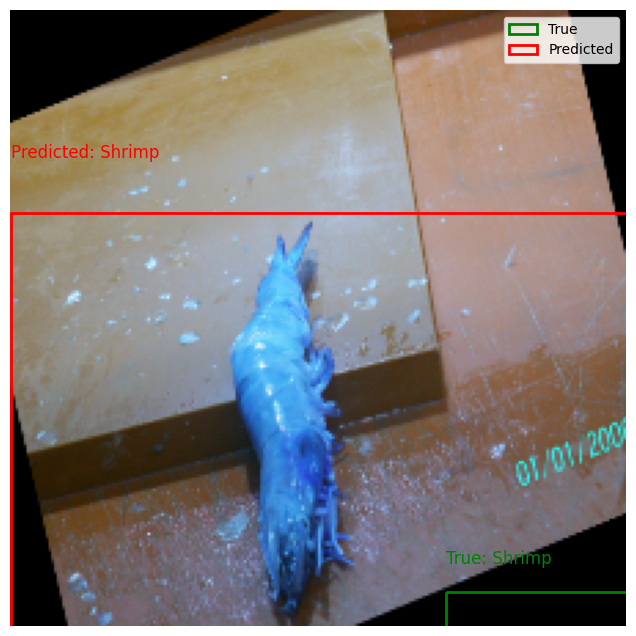

In [60]:
# %% Visualize Predictions with Bounding Boxes
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

def visualize_predictions(model, dataset, label_encoder, num_images=5):
    for images, targets in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_bbox = targets['bbox'][i].numpy() * [224, 224, 224, 224]  # Denormalize bbox
            pred_bbox = predictions['bbox'][i] * [224, 224, 224, 224]  # Denormalize bbox
            true_category = label_encoder.inverse_transform([targets['category'][i].numpy()])[0]
            pred_category = label_encoder.inverse_transform([np.argmax(predictions['category'][i])])[0]

            # Plot image
            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            plt.axis('off')

            # Draw true bbox
            plt.gca().add_patch(
                plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1],
                              fill=False, edgecolor='green', linewidth=2, label="True")
            )
            plt.text(true_bbox[0], true_bbox[1] - 10, f"True: {true_category}", color="green", fontsize=12)

            # Draw predicted bbox
            plt.gca().add_patch(
                plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1],
                              fill=False, edgecolor='red', linewidth=2, label="Predicted")
            )
            plt.text(pred_bbox[0], pred_bbox[1] - 20, f"Predicted: {pred_category}", color="red", fontsize=12)

            plt.legend(loc="upper right")
            plt.show()

visualize_predictions(model, val_dataset, label_encoder, num_images=5)
